In [1]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from tqdm import tqdm
from pathlib import Path
import os
cwd = Path(os.getcwd())

tqdm.pandas()

In [2]:
class cfg: 
    BASE_PATH = cwd / '../Data'
    CSV_PATH = BASE_PATH/'train.csv'
    SEMI_PATH = BASE_PATH/'train_semi_supervised'
    CELL_TYPE = ['shsy5y', 'astro', 'cort']
    WIDTH, HEIGHT = 520, 704

In [3]:
train_df = pd.read_csv(cfg.CSV_PATH)
train_df['image_path'] = train_df['id'].apply(lambda x : (cfg.BASE_PATH/'train'/x).with_suffix('.png'))

In [4]:
train_df.head()

id                                         annotation  width  \
0  0030fd0e6378  118145 6 118849 7 119553 8 120257 8 120961 9 1...    704   
1  0030fd0e6378  189036 1 189739 3 190441 6 191144 7 191848 8 1...    704   
2  0030fd0e6378  173567 3 174270 5 174974 5 175678 6 176382 7 1...    704   
3  0030fd0e6378  196723 4 197427 6 198130 7 198834 8 199538 8 2...    704   
4  0030fd0e6378  167818 3 168522 5 169225 7 169928 8 170632 9 1...    704   

   height cell_type plate_time sample_date  \
0     520    shsy5y  11h30m00s  2019-06-16   
1     520    shsy5y  11h30m00s  2019-06-16   
2     520    shsy5y  11h30m00s  2019-06-16   
3     520    shsy5y  11h30m00s  2019-06-16   
4     520    shsy5y  11h30m00s  2019-06-16   

                            sample_id elapsed_timedelta  \
0  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00   
1  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00   
2  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00   
3  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00   
4  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00   

                                          image_path  
0  /Users/kwon/Workspace/Python/cell-detection-yo...  
1  /Users/kwon/Workspace/Python/cell-detection-yo...  
2  /Users/kwon/Workspace/Python/cell-detection-yo...  
3  /Users/kwon/Workspace/Python/cell-detection-yo...  
4  /Users/kwon/Workspace/Python/cell-detection-yo...

# Count by cell type

<Axes: xlabel='width', ylabel='height'>

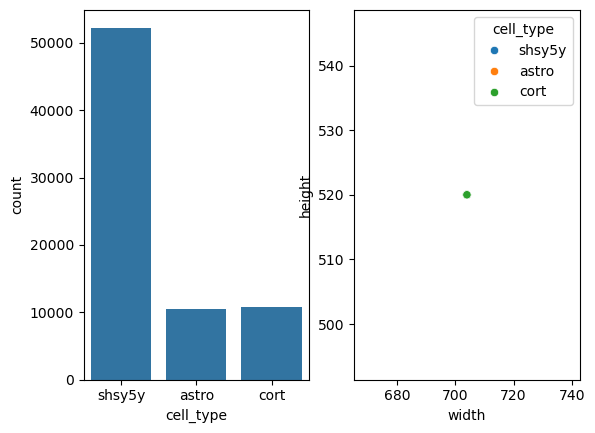

In [5]:
fig,axs = plt.subplots(1,2)
sns.countplot(data=train_df, x='cell_type',ax=axs[0])
sns.scatterplot(data=train_df, x='width',y='height',hue='cell_type', ax=axs[1])

In [6]:
unique_id, idxes = np.unique(train_df['id'].values, return_index=True)
print(f'Total image count : {len(unique_id)}')

total_id_count_dict = {'id':[], 'count':[], 'cell_type':[]}
for uid, idx in tqdm(zip(unique_id, idxes), total=len(idxes)):
    sample_df = train_df.iloc[idx]
    cell_count = len(train_df[train_df['id'] == uid])
    cell_type = sample_df['cell_type']
    
    total_id_count_dict['id'].append(uid)
    total_id_count_dict['count'].append(cell_count)
    total_id_count_dict['cell_type'].append(cell_type)
cell_count_df = pd.DataFrame(total_id_count_dict)

Total image count : 606


100%|██████████| 606/606 [00:01<00:00, 470.59it/s]


# Count each cell with each image type

<Axes: xlabel='count', ylabel='Count'>

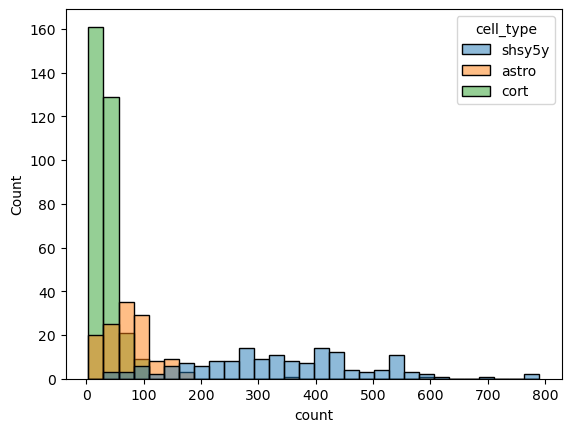

In [7]:
sns.histplot(cell_count_df, x='count', hue='cell_type')

# Display Each cell type

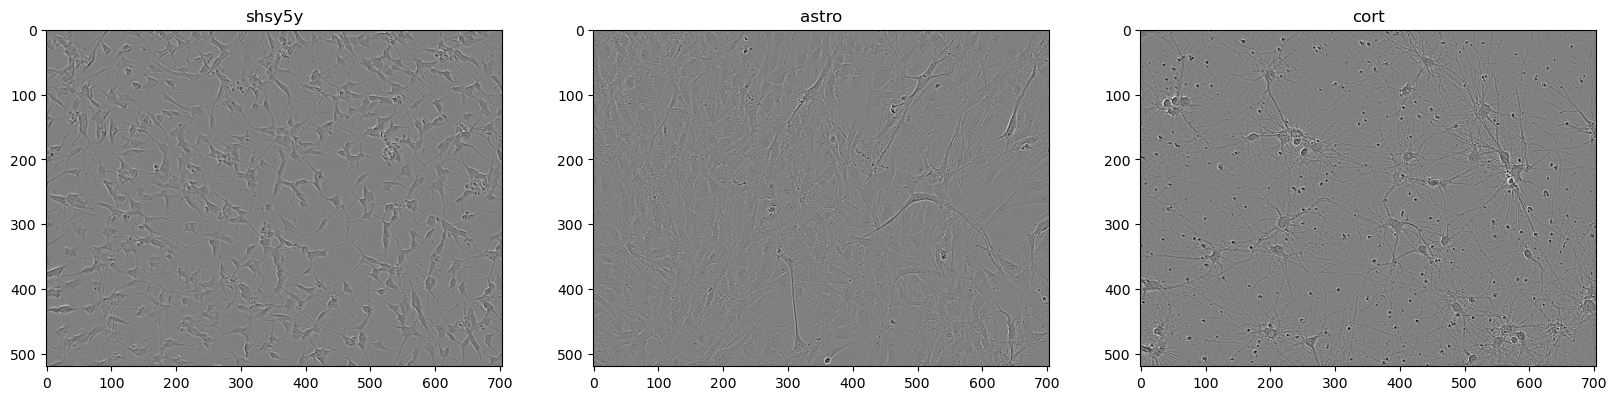

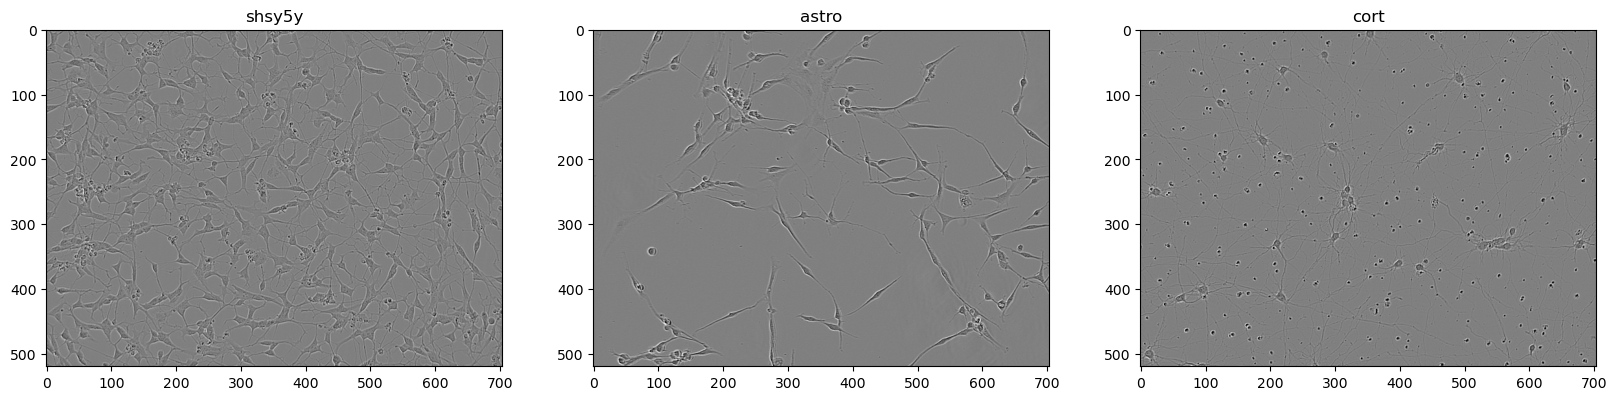

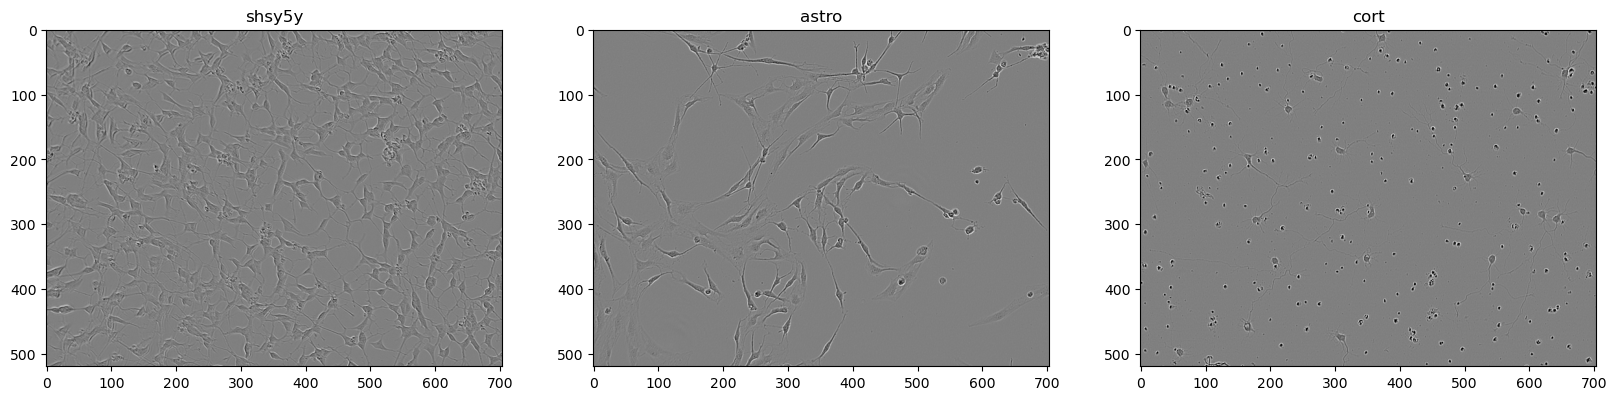

In [8]:
for _ in range(3): 
    fig, axs = plt.subplots(1, 3, figsize=(20, 20))
    for idx, i in enumerate(cfg.CELL_TYPE): 
        sample = train_df[train_df['cell_type'] == i].sample(1).iloc[0]
        img = cv2.imread(sample['image_path'])
        axs[idx].imshow(img)
        axs[idx].set_title(i) 
    plt.show()


In [9]:
def get_box(a_mask):
    ''' Get the bounding box of a given mask '''
    pos = np.where(a_mask)
    xmin = np.min(pos[1])
    xmax = np.max(pos[1])
    ymin = np.min(pos[0])
    ymax = np.max(pos[0])
    return [xmin, ymin, xmax, ymax]


def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)
    



def build_masks(img, mask, colors=True, return_bbox=False):
    height, width, _ = img.shape
    labels = mask
    if colors:
        mask = np.zeros((height, width, 3))
        for label in labels:
            c_mask = np.array(rle_decode(label, shape=(height,width , 3), color=np.random.rand(3)))
            mask += c_mask
    else:
        mask = np.zeros((height, width, 1))
        boxes = []
        for cls_num, label in enumerate(labels):
            g_mask = np.array(rle_decode(label, shape=(height, width, 1)))
            mask += g_mask
            boxes.append(get_box(g_mask))
            
    mask = mask.clip(0, 1)
    if return_bbox: 
        return boxes
    else: 
        return mask


In [10]:
def cell_type_plot_with_mask(df, plot_mask=True): 
    fig, axs = plt.subplots(3, 2, figsize=(20,20))
    
    for idx, i in enumerate(cfg.CELL_TYPE): 
        sample = df[df['cell_type'] == i].sample(1).iloc[0]
        img = cv2.imread(str(sample['image_path']))
        mask = build_masks(img, sample['annotation'], colors=False)
        
        if plot_mask: 
            axs[idx, 0].imshow(img)
            axs[idx, 1].imshow(mask)
        else:
            axs[idx].imshow(img)        
    

In [11]:
def cell_type_plot_with_mask(df, plot_mask=True): 
    fig, axs = plt.subplots(3, 3, figsize=(20,20))

    for idx, i in enumerate(cfg.CELL_TYPE): 
        sample = df[df['cell_type'] == i]
        uides, idxes = np.unique(sample['id'].values, return_index=True)
        uid = np.random.choice(uides, 1)[0]

        cell_df = sample[sample['id'] == uid]

        img = cv2.imread(str(cell_df.iloc[0]['image_path']))
        gray_mask = build_masks(img, cell_df['annotation'].to_list(), colors=False)
        color_mask = build_masks(img, cell_df['annotation'].to_list(), colors=True)
        
        merged = cv2.addWeighted(img, 0.75, np.array(color_mask*255).astype(np.uint8), 0.25, 0.0,)
#         
        axs[idx, 0].imshow(img)
        axs[idx, 1].imshow(color_mask)
        axs[idx, 2].imshow(merged)


In [12]:
def get_img_and_mask(img_path, annotation, width, height, mask_only=False, rle_fn=rle_decode):
    """ Capture the relevant image array as well as the image mask """
    img_mask = np.zeros((height, width), dtype=np.uint8)
    for i, annot in enumerate(annotation): 
        img_mask = np.where(rle_fn(annot, (height, width))!=0, i, img_mask)
    
    # Early Exit
    if mask_only:
        return img_mask
    
    # Else Return images
    img = tf_load_png(img_path)[..., 0]
    return img, img_mask

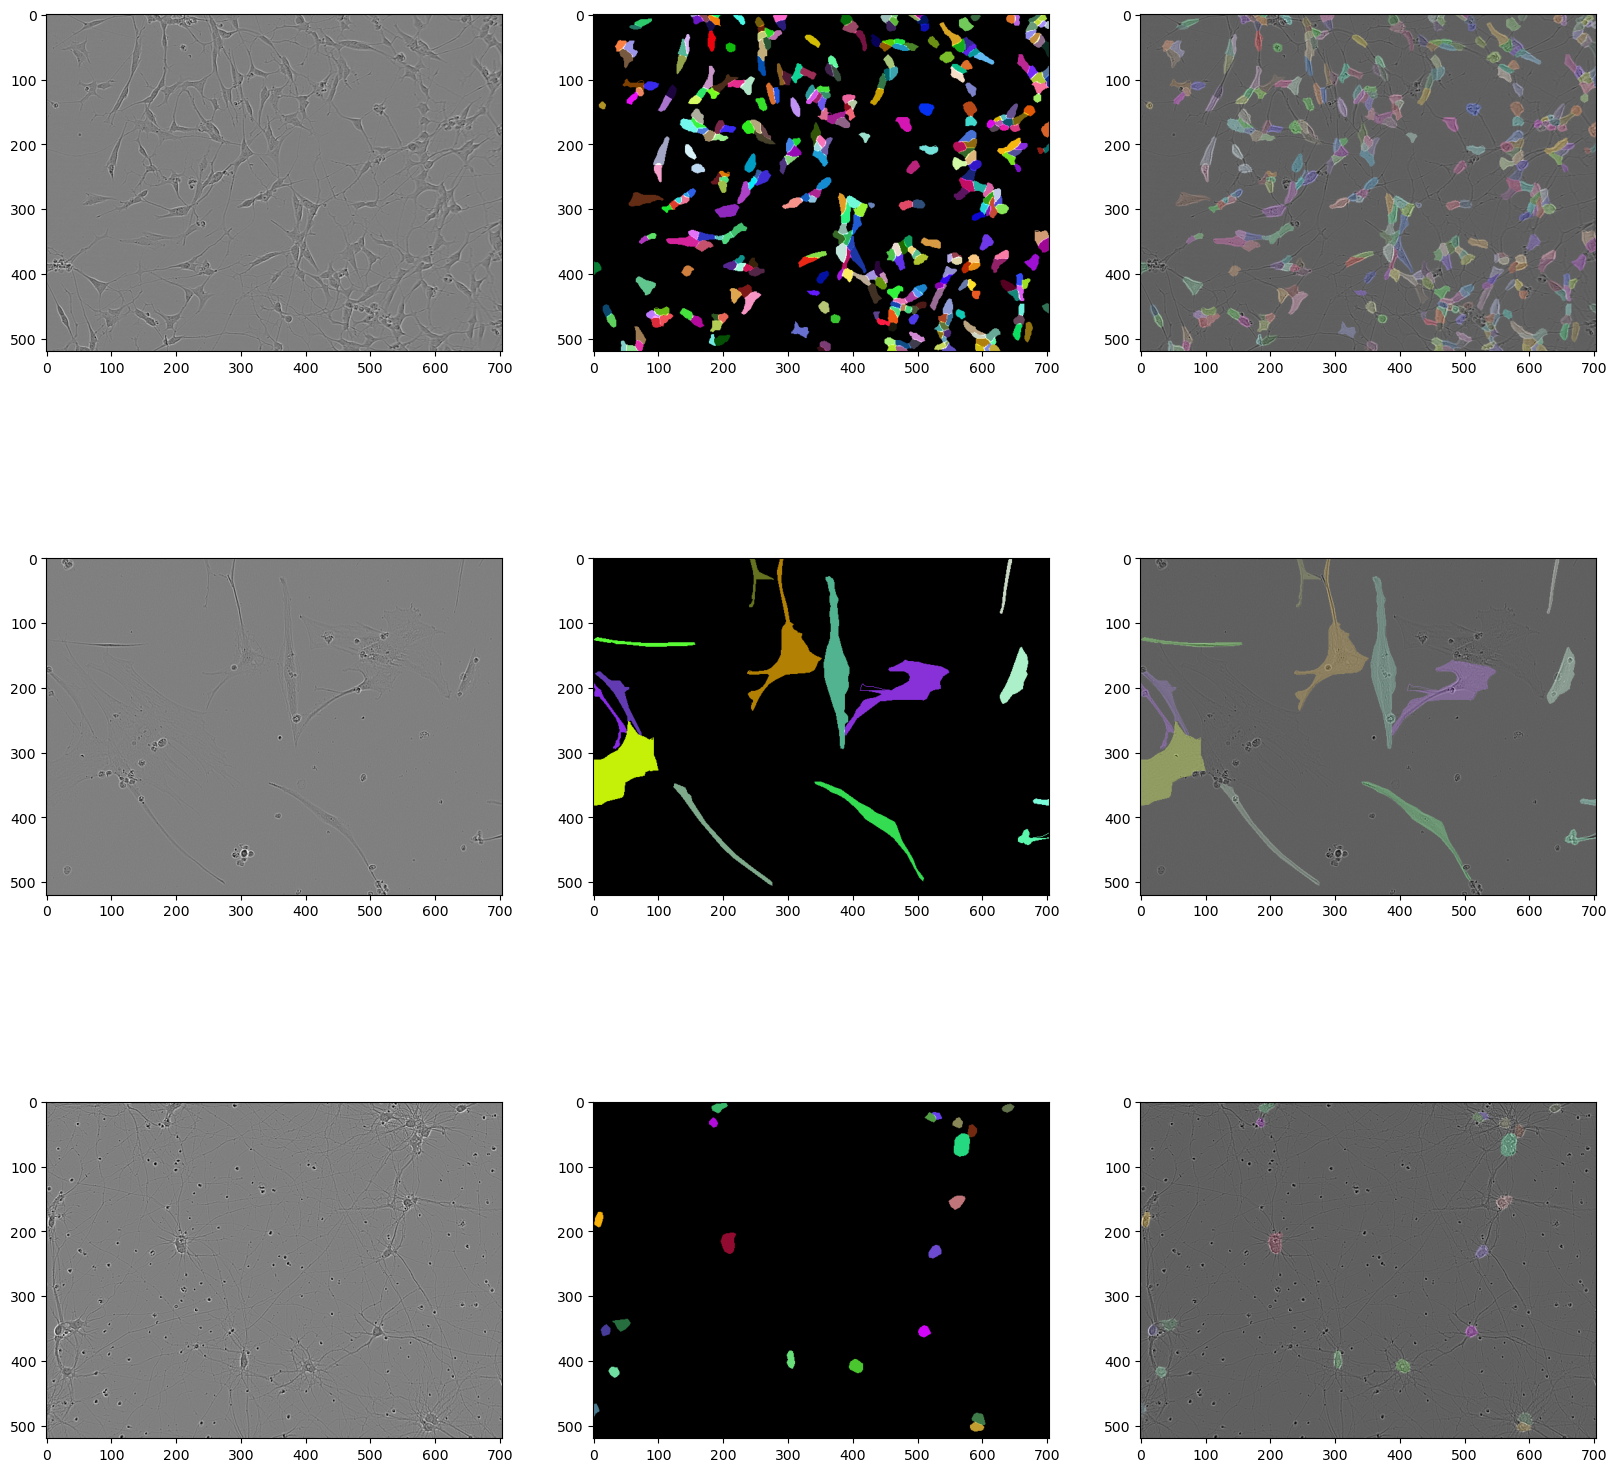

In [13]:
cell_type_plot_with_mask(train_df)

# Get BBox

In [14]:
def pd_get_bboxes(row):
    """ Get all bboxes for a given row/cell-image """
    mask = np.array(rle_decode(row.annotation, shape=(row.height, row.width, 1)))
    return get_box(mask)

In [16]:
train_df['bbox'] = train_df.progress_apply(pd_get_bboxes, axis=1)

100%|██████████| 73585/73585 [02:03<00:00, 594.41it/s]


In [17]:
box_df = pd.DataFrame(train_df['bbox'].to_list(), columns=['x1','y1','x2','y2'])
box_df['area'] = (box_df['x2'] - box_df['x1']) * (box_df['y2'] - box_df['y1'])
box_df['box_width'] = box_df['x2'] - box_df['x1']
box_df['box_hight'] = box_df['y2'] - box_df['y1']

In [18]:
final_df = pd.concat([train_df, box_df], axis=1)

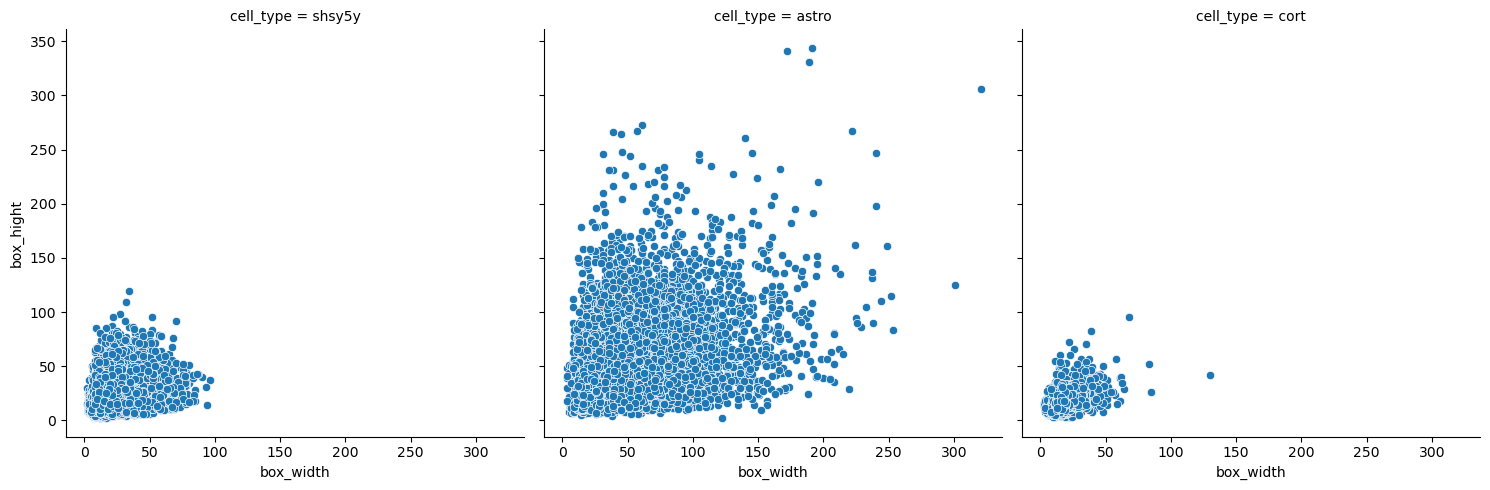

In [19]:
sns.relplot(final_df, x='box_width', y='box_hight', col='cell_type')

In [20]:
def cell_type_plot_with_bbox(df, plot_mask=True): 
    fig, axs = plt.subplots(3, 3, figsize=(20,20))

    for idx, i in enumerate(cfg.CELL_TYPE): 
        sample = df[df['cell_type'] == i]
        uides, idxes = np.unique(sample['id'].values, return_index=True)
        uid = np.random.choice(uides, 1)[0]

        cell_df = sample[sample['id'] == uid]

        img = cv2.imread(str(cell_df.iloc[0]['image_path']))
        
        bboxes = build_masks(img, cell_df['annotation'].to_list(), colors=False, return_bbox=True)
        color_mask = build_masks(img, cell_df['annotation'].to_list(), colors=True)
        
        merged = cv2.addWeighted(img, 0.75, np.array(color_mask*255).astype(np.uint8), 0.25, 0.0,)
#         
        axs[idx, 0].imshow(img)
        axs[idx, 1].imshow(color_mask)
        box_img = img.copy()
        for i in bboxes: 
            box_img = cv2.rectangle(box_img, (i[0], i[1]), (i[2],i[3]), (255,0,0),1)
        axs[idx, 2].imshow(box_img)


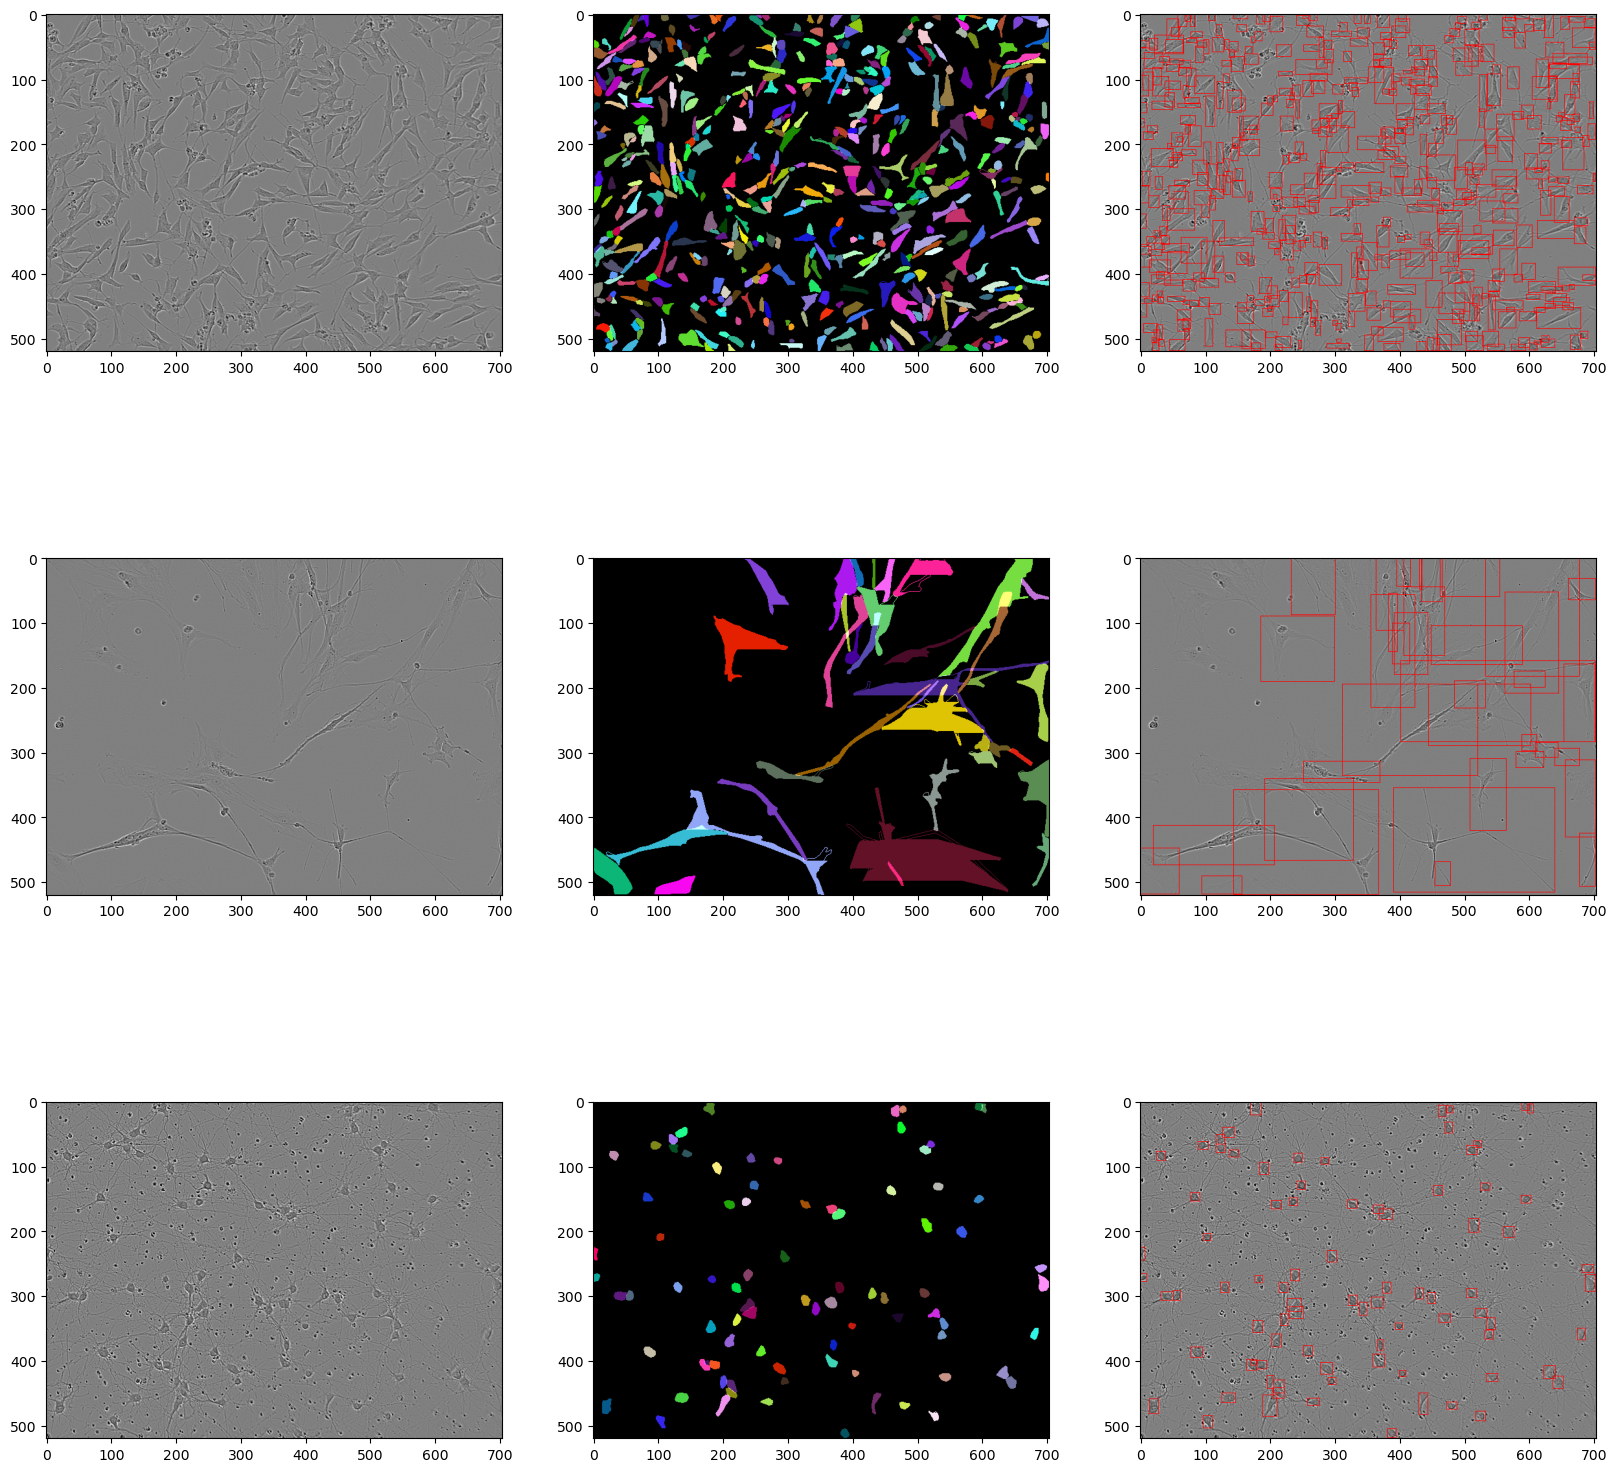

In [21]:
cell_type_plot_with_bbox(train_df)